In [1]:
! pip install sentencepiece

In [2]:
import csv
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

import sentencepiece as spm
tf.__version__

'2.3.0'

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12232319316609294412
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5985829364406184040
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7254615537378924000
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6700785586732838333
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### data load

In [5]:
train = pd.read_csv('./train.csv').fillna('')
test = pd.read_csv('./test.csv').fillna('')
train = train[['query', 'product_title', 'product_description']]
test = test[['query', 'product_title', 'product_description']]
train = pd.concat([train, test])

In [6]:
train['query'] = train.apply(lambda x: x['query'].lower(), axis=1)
train['product_title'] = train.apply(lambda x: x['product_title'].lower(), axis=1)
train['product_description'] = train.apply(lambda x: x['product_description'].lower(), axis=1)

In [7]:
sentences_train = list(train['query'].unique()) + \
                  list(train['product_title'].unique()) + \
                  list(train['product_description'].unique())

In [8]:
with open('./sentences_.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(sentences_train))

In [9]:
parameter = '--input={} --model_prefix={} --vocab_size={} --user_defined_symbols={} --model_type={}'

input_file = './sentences_.txt'
model_prefix = 'sentences_'
vocab_size = 1500
user_defined_symbols = '▁[PAD],▁[UNK],▁[CLS],▁[SEP],▁[MASK]'
model_type = 'bpe'

cmd = parameter.format(input_file, model_prefix, vocab_size, user_defined_symbols, model_type)
spm.SentencePieceTrainer.Train(cmd)

In [10]:
vocab_list = pd.read_csv('./sentences_.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_size = len(vocab_list)

In [11]:
sp = spm.SentencePieceProcessor()
vocab_file = './sentences_.model'
sp.load(vocab_file)

True

In [12]:
train['query_processed'] = train.apply(lambda x: sp.encode_as_ids(x['query']), axis=1)
train['product_title_processed'] = train.apply(lambda x: sp.encode_as_ids(x['product_title']), axis=1)
train['product_description_processed'] = train.apply(lambda x: sp.encode_as_ids(x['product_description']), axis=1)
train['NSP_label'] = train.apply(lambda x: 0 if random.uniform(0, 1) <0.5 else 1, axis=1)

In [13]:
q_dict = {}
for q in train['query'].unique():
    q_dict[q] = train.groupby('query').get_group(q)['product_title_processed']

In [14]:
temp = list(train['query'].unique())
def sentence_change(x):
    if x['NSP_label'] == 0:
        tmp = random.choice(temp)
        while tmp == x['query']:
            tmp = random.choice(temp)
        return random.choice(list(q_dict[tmp]))
    return x['product_title_processed']

In [15]:
train['changed_product_title'] = train.apply(lambda x: sentence_change(x), axis=1)

In [16]:
del q_dict

In [17]:
def _mask(x):
    new_query = []
    masked_indexes = []
    for i, w in enumerate(x):
        if random.uniform(0, 1) <= 0.15:
            if random.uniform(0, 1) <= 0.8:
                new_query.append(7)
                masked_indexes.append(i)
            elif random.uniform(0, 1) <= 0.5:
                random_word = random.randint(8, vocab_size-8)
                new_query.append(random_word)
                masked_indexes.append(i)
            else :
                new_query.append(w)
                masked_indexes.append(i)
        else :
            new_query.append(w)
    return new_query, masked_indexes

In [18]:
def test_func(x):
    query, label = _mask(x['query_processed'])
    x['masked_query'] = [5] + query + [6]
    query_label = [l+1 for l in label]
    title, label = _mask(x['changed_product_title'])
    x['masked_product_title'] = title + [6]
    title_label = [l+len(x['masked_query']) for l in label]
    x['LM_label_idx'] = query_label + title_label
    return x

In [19]:
train = train.apply(test_func, axis=1)

In [20]:
def gen_pair_label(x):
    return [5] + x['query_processed'] + [6] + x['changed_product_title'] + [6]

In [21]:
train['original_label'] = train.apply(lambda x: gen_pair_label(x), axis=1)

In [22]:
def get_LM_label(x):
    return [x['original_label'][i] for i in x['LM_label_idx']]

In [23]:
train['LM_label'] = train.apply(lambda x: get_LM_label(x), axis=1)

In [24]:
max_len = train.masked_query.map(len).max() + train.masked_product_title.map(len).max()
label_max_len = train.LM_label_idx.map(len).max()

In [25]:
train['sentence_pair'] = train.apply(lambda x: x['masked_query'] + x['masked_product_title'], axis=1)

In [26]:
train['sentence_token_type'] = train.apply(lambda x: np.concatenate((np.ones(len(x['masked_query']), dtype=int), np.ones(len(x['masked_product_title']), dtype=int)+1), axis=0), axis=1) 

In [27]:
print(train['sentence_pair'].iloc[0])
print(train['original_label'].iloc[0])
print()
print(train['LM_label_idx'].iloc[0])
print(train['LM_label'].iloc[0])
print()
print(sp.DecodeIds(train['sentence_pair'].iloc[0]))
print(sp.DecodeIds(train['original_label'].iloc[0]))

[5, 335, 78, 41, 7, 370, 736, 772, 6, 954, 1421, 7, 141, 7, 167, 151, 310, 1398, 1265, 700, 7, 1402, 273, 1401, 260, 80, 118, 493, 1035, 865, 6]
[5, 335, 78, 41, 117, 370, 736, 772, 6, 954, 1421, 1388, 141, 12, 167, 151, 310, 1398, 16, 700, 49, 1402, 273, 1401, 260, 80, 118, 493, 1035, 865, 6]

[4, 11, 13, 18, 20]
[117, 1388, 12, 16, 49]

[CLS] bridal [MASK]ower decorations [SEP] girl' [MASK] ch [MASK]okee greg whoia [MASK]wboy boot - assorted colors [SEP]
[CLS] bridal shower decorations [SEP] girl's cherokee gregoria cowboy boot - assorted colors [SEP]


#### Hyper parameter

In [28]:
# voca 수
vocab_size = len(vocab_list)

# 임베딩 벡터의 크기
d_model = 256

# encoder layer 수
num_layers = 4

# attentin 수
num_heads = 4
depth = d_model/num_heads

# max_len = train.masked_query.map(len).max() + train.masked_product_title.map(len).max()

In [29]:
print(max_len, label_max_len)

128 23


In [30]:
class Data(object):
    def __init__(self, data_frame, seq_max_len, label_max_len, tts=False):
        self.seq_max_len = seq_max_len
        self.label_max_len = label_max_len
        if tts == True:
          train, dev = train_test_split(data_frame, test_size=0.15)
          ((self.train_x, self.train_x_token, self.train_y_idx, self.train_y_lm, self.train_y_nsp), 
          (self.dev_x, self.dev_x_token, self.dev_y_idx, self.dev_y_lm, self.dev_y_nsp)) = map(self.data_gen, [train, dev])
        else:
          self.train_x, self.train_x_token, self.train_y_idx, self.train_y_lm, self.train_y_nsp = self.data_gen(data_frame)
    def data_gen(self, df):
        x = tf.keras.preprocessing.sequence.pad_sequences(df['sentence_pair'], padding="post", maxlen=self.seq_max_len)
        x_token = tf.keras.preprocessing.sequence.pad_sequences(df['sentence_token_type'], padding="post", maxlen=self.seq_max_len)
        y_idx = tf.keras.preprocessing.sequence.pad_sequences(df['LM_label_idx'], padding="post", maxlen=self.label_max_len)
        y_lm = tf.keras.preprocessing.sequence.pad_sequences(df['LM_label'], padding="post", maxlen=self.label_max_len)
        y_nsp = df['NSP_label'].values
        return x, x_token, y_idx, y_lm, y_nsp

In [31]:
# max_len = 130
# label_max_len = 35
data = Data(train, max_len, label_max_len, tts=True)

In [32]:
class Bert_Embedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_len, name='Bert_Embedding'):
        super(Bert_Embedding, self).__init__(name=name)
        self._supports_ragged_inputs = True 
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_len = max_len
        self.Token_Embedding = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.d_model, mask_zero=True)
        self.Segment_Embedding = tf.keras.layers.Embedding(input_dim=3, output_dim=self.d_model, mask_zero=True)
        self.Position_Embedding = tf.keras.layers.Embedding(input_dim=self.max_len, output_dim=self.d_model)
        self.norm =  tf.keras.layers.LayerNormalization(name='LayerNorm')

        
    def call(self, inputs):
        T_embedding = self.Token_Embedding(inputs['inputs'])
        S_embedding = self.Segment_Embedding(inputs['inputs_token_type'])
        P_embedding = self.Position_Embedding(tf.cumsum(tf.ones_like(inputs['inputs']), axis=1)-1)
        embedding = tf.math.add_n([T_embedding, S_embedding, P_embedding])
        embedding = self.norm(embedding)
        return embedding, T_embedding._keras_mask

In [33]:
# inputs = {'inputs' : data.dev_x,
#           'inputs_token_type' : data.dev_x_token}

# bert_embedding = Bert_Embedding(vocab_size, d_model, max_len)
# embedding, mask = bert_embedding(inputs)
# embedding.shape

In [34]:
class Scaled_Dot_Product_Attention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='Scaled_Dot_Product_Attention'):
        super(Scaled_Dot_Product_Attention, self).__init__(name=name)
        self._supports_ragged_inputs = True
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = self.d_model/self.num_heads
        self.Q_layer = tf.keras.layers.Dense(units=self.depth, name='Query')
        self.K_layer = tf.keras.layers.Dense(units=self.depth, name='Key')
        self.V_layer = tf.keras.layers.Dense(units=self.depth, name='Value')
    
    def zero_mask_(self, mask):
        mask = tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)
        return tf.cast(tf.math.logical_not(tf.cast(tf.matmul(mask, mask, transpose_b=True), tf.bool)), tf.float32)
    
    def call(self, inputs, mask):
        zero_mask = self.zero_mask_(mask)

        query = self.Q_layer(inputs)
        key = self.K_layer(inputs)
        value = self.K_layer(inputs)
        
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        logits = tf.math.divide(matmul_qk, tf.math.sqrt(self.depth))
        logits += (zero_mask * -1e9)
        
        attention = tf.nn.softmax(logits, axis=-1)
        attention = tf.matmul(attention, value)
        return attention
    
    def compute_output_shape(self, inputs):
        return (inputs.shape[0], None, self.d_model)
    

In [35]:
# scaled_Dot_Product_Attention = Scaled_Dot_Product_Attention(d_model, num_heads, name='Scaled_Dot_Product_Attention')
# attention_value = scaled_Dot_Product_Attention(embedding, mask)
# attention_value.shape

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self._supports_ragged_inputs = True
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads
        self.scaled_dot_product_attention_dict = {}
        for i in range(self.num_heads):
            self.scaled_dot_product_attention_dict[i] = Scaled_Dot_Product_Attention(self.d_model, self.num_heads)
        self.dense = tf.keras.layers.Dense(units=self.d_model, name='MultiHeadAttention_Dense')

    def call(self, inputs, mask):
        attention_value_dict = {}
        for i in range(self.num_heads):
            attention_value_dict[i] = self.scaled_dot_product_attention_dict[i](inputs, mask)
        concat_attention = tf.concat([attention_value_dict[i] for i in range(self.num_heads)], axis=-1)
        
        outputs = self.dense(concat_attention)
        return outputs
    
    def compute_output_shape(self, inputs):
        return (inputs.shape[0], None, self.d_model)

In [37]:
# multiheadattention = MultiHeadAttention(d_model, num_heads)
# multiheadattentionmatrix = multiheadattention(embedding, mask)
# multiheadattentionmatrix.shape

In [38]:
class Add_and_Norm(tf.keras.layers.Layer):
    def __init__(self, name='Add_and_Norm'):
        super(Add_and_Norm, self).__init__(name=name)
        self._supports_ragged_inputs = True
        self.drop_out = tf.keras.layers.Dropout(rate=0.1)
        self.norm =  tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, residual):
        x = self.drop_out(inputs)
        x = self.norm(x)
        x = tf.keras.layers.add([x, residual])
        return x
    
    def compute_output_shape(self, inputs):
        return (inputs.shape)

In [39]:
# add_and_norm_1 = Add_and_Norm()
# norm_1 = add_and_norm_1(multiheadattentionmatrix, embedding)
# norm_1.shape

In [40]:
class Feed_Forward_NN(tf.keras.layers.Layer):
    def __init__(self, d_model, name='Feed_Forward_NN'):
        super(Feed_Forward_NN, self).__init__(name=name)
        self._supports_ragged_inputs = True
        self.d_model = d_model
        self.dff = self.d_model * 4
        self.layer1 = tf.keras.layers.Dense(units=self.dff, activation='relu')
        self.layer2 = tf.keras.layers.Dense(units=self.d_model)

        
    def call(self, inputs):
        x = self.layer1(inputs) 
        x = self.layer2(x)
        return x

In [41]:
# feed_forward_NN = Feed_Forward_NN(d_model)
# ffnn = feed_forward_NN(multiheadattentionmatrix)
# ffnn.shape

In [42]:
# add_and_norm_2 = Add_and_Norm()
# norm_2 = add_and_norm_1(ffnn, norm_1)
# norm_2.shape

In [43]:
tf.keras.backend.clear_session()

embedding_inputs = {'inputs':tf.keras.Input(shape=(max_len, ), dtype=tf.int64, name='masked_query'),
                    'inputs_token_type' :tf.keras.Input(shape=(max_len, ), dtype=tf.int32, name='masked_product_title')}
LM_label_idx = tf.keras.Input(shape=(label_max_len, ), dtype=tf.int32, name='LM_label_idx')

x, mask = Bert_Embedding(vocab_size, d_model, max_len)(inputs=embedding_inputs)

for i in range(num_layers):
    mha = MultiHeadAttention(d_model, num_heads, name='MultiHeadAttention_%d'%(i+1))(x, mask)
    mha_dropout = tf.keras.layers.Dropout(rate=0.1)(mha)
    mha_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(mha_dropout)
    x = tf.keras.layers.add([mha_norm, x])
    ffnn = Feed_Forward_NN(d_model, name='Feed_Forward_NN_%d'%(i+1))(x)
    ffnn_dropout = tf.keras.layers.Dropout(rate=0.1)(ffnn)
    ffnn_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ffnn_dropout)
    x = tf.keras.layers.add([ffnn_norm, x])
    
nsp_output = tf.keras.layers.Dense(1, activation='sigmoid', name='nsp')(x[:,0,:])
    
lm_x = tf.keras.layers.Dense(d_model, activation='relu', name='classification_layer')(x)
lm_x = tf.keras.layers.Dropout(rate=0.1)(lm_x)
lm_x = tf.keras.layers.LayerNormalization(name='classification_norm')(lm_x)
lm_x = tf.keras.layers.Dense(vocab_size, activation='softmax', name='lm_layer')(lm_x)
lm_output = tf.gather(lm_x, LM_label_idx, batch_dims=1, name='lm')

model = tf.keras.Model(inputs=[embedding_inputs, LM_label_idx], outputs=[lm_output, nsp_output])

In [44]:
def lm_loss(y_true, y_pred):
    mask = tf.cast(tf.greater(y_true, 1), tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss = tf.math.multiply(loss, mask)
    loss = tf.divide(tf.reduce_sum(loss), tf.reduce_sum(mask))
    return loss
    
def nsp_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.keras.backend.mean(loss)

In [45]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
masked_query (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_product_title (InputLaye [(None, 128)]        0                                            
__________________________________________________________________________________________________
Bert_Embedding (Bert_Embedding) ((None, 128, 256), ( 418048      masked_query[0][0]               
                                                                 masked_product_title[0][0]       
__________________________________________________________________________________________________
MultiHeadAttention_1 (MultiHead (None, 128, 256)     197376      Bert_Embedding[0][0]  

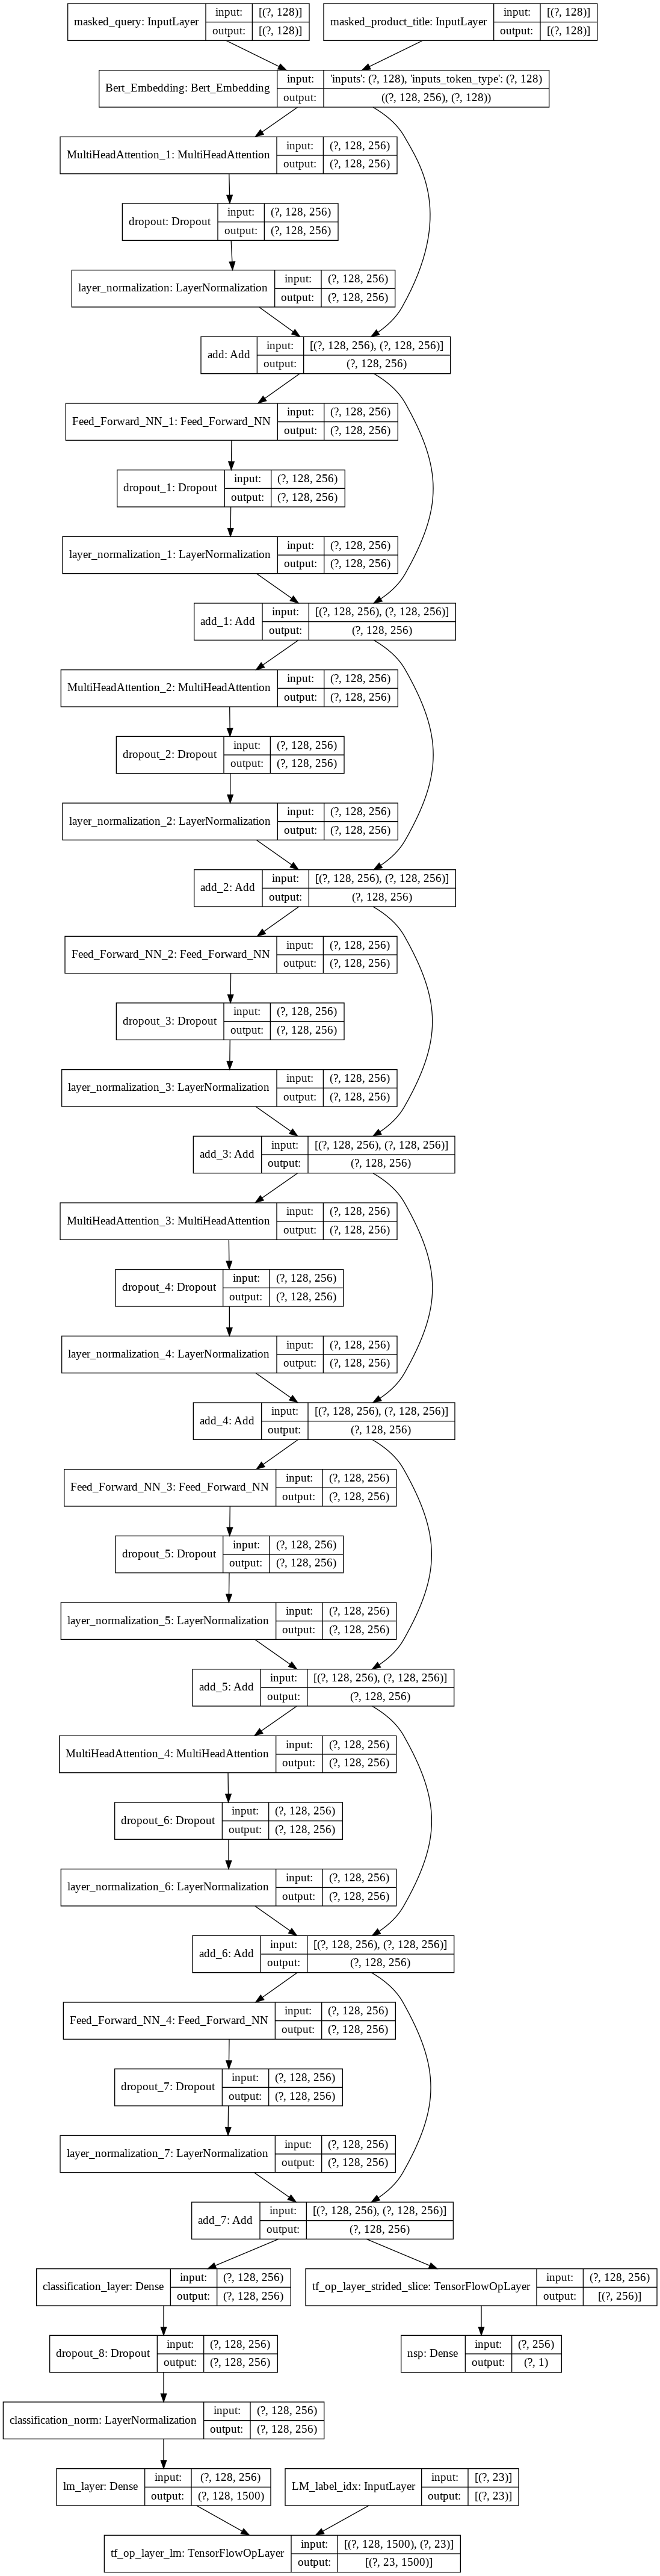

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
class _Acurracy_Check:
    def __init__(self):
        self._acurracy = None
        
acurracy_obj = _Acurracy_Check()

@tf.function
def masked_accuracy(y_true, y_pred):
    if acurracy_obj._acurracy is None:
        acurracy_obj._acurracy = tf.keras.metrics.Accuracy()
    mask = tf.cast(tf.math.greater_equal(y_true, 1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    return acurracy_obj._acurracy(y_true, y_pred, sample_weight=mask)

In [55]:
inputs = [{'inputs' : data.train_x, 'inputs_token_type' : data.train_x_token}, data.train_y_idx]
label = {"tf_op_layer_lm": data.train_y_lm, "nsp": data.train_y_nsp}

inputs_dev = [{'inputs' : data.dev_x, 'inputs_token_type' : data.dev_x_token}, data.dev_y_idx]
label_dev = {"tf_op_layer_lm": data.dev_y_lm, "nsp": data.dev_y_nsp}

In [56]:
from tensorflow.keras import backend as K

def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)

In [57]:
class WarmUpCosineDecayScheduler(tf.keras.callbacks.Callback):

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = [0]
        
    def on_epoch_begin(self, epoch, logs=None):
        if self.verbose > 0:
            print('rate to %s.' % (self.learning_rates[-1]))
            
    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)

In [58]:
# Number of training samples.
sample_count = len(data.train_x)

# Total epochs to train.
epochs = 30

# Number of warmup epochs.
warmup_epoch = 3

# Training batch size, set small value here for demonstration purpose.
batch_size = 64

# Base learning rate after warmup.
learning_rate_base = 0.005

total_steps = int(epochs * sample_count / batch_size)

# Compute the number of warmup batches.
warmup_steps = int(warmup_epoch * sample_count / batch_size)

# Compute the number of warmup batches.
warmup_batches = warmup_epoch * sample_count / batch_size

# Create the Learning rate scheduler.
warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                        total_steps=total_steps,
                                        warmup_learning_rate=0.0,
                                        warmup_steps=warmup_steps,
                                        hold_base_rate_steps=1e-4,
                                        verbose=0)

In [59]:
model.compile(optimizer='Adam',
              loss={'tf_op_layer_lm':lm_loss, 'nsp': nsp_loss},
              metrics={'tf_op_layer_lm': masked_accuracy, 'nsp': 'accuracy'})      

In [60]:
total_epoch_count = epochs
batch_size = batch_size
model.fit(x=inputs, y=label,
          validation_data=(inputs_dev, label_dev),
          shuffle=True,
          epochs=total_epoch_count,
          batch_size=batch_size,
          callbacks=[warm_up_lr])
          # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/30
434/434 [==============================] - 46s 106ms/step - loss: 7.2697 - tf_op_layer_lm_loss: 6.4236 - nsp_loss: 0.8461 - tf_op_layer_lm_masked_accuracy: 0.0124 - nsp_accuracy: 0.5062 - val_loss: 6.8265 - val_tf_op_layer_lm_loss: 6.1012 - val_nsp_loss: 0.7253 - val_tf_op_layer_lm_masked_accuracy: 0.0181 - val_nsp_accuracy: 0.4923
Epoch 2/30
434/434 [==============================] - 43s 100ms/step - loss: 6.2477 - tf_op_layer_lm_loss: 5.5248 - nsp_loss: 0.7229 - tf_op_layer_lm_masked_accuracy: 0.0340 - nsp_accuracy: 0.5339 - val_loss: 5.5595 - val_tf_op_layer_lm_loss: 4.8867 - val_nsp_loss: 0.6728 - val_tf_op_layer_lm_masked_accuracy: 0.0650 - val_nsp_accuracy: 0.5729
Epoch 3/30
434/434 [==============================] - 43s 99ms/step - loss: 5.1403 - tf_op_layer_lm_loss: 4.4507 - nsp_loss: 0.6895 - tf_op_layer_lm_masked_accuracy: 0.0958 - nsp_accuracy: 0.5714 - val_loss: 4.7286 - val_tf_op_layer_lm_loss: 4.0185 - val_nsp_loss: 0.7101 - val_tf_op_layer_lm_masked_accuracy: 

In [61]:
print_num = 10
pp = model.predict([{'inputs' : data.dev_x[:print_num], 'inputs_token_type' : data.dev_x_token[:print_num]}, data.dev_y_idx[:print_num]])

In [62]:
mask = tf.cast(tf.greater(data.dev_y_lm[:print_num], 1), tf.float32)
y_preds = tf.cast(tf.argmax(pp[0], axis=-1), tf.float32)
y_ = tf.cast(tf.math.multiply(y_preds, mask), tf.int32)

In [63]:
print(y_.numpy())

[[1130  937  152   50    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [  31 1413 1418 1026   74    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [  89 1386  976    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [1418    8    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 802  234   14   65 1408   93   53  118    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 222  259   12    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 879  710   12 1027  580  183  153    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 223   33 1408    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [  28  867 1409 1408    0    0    0    

In [64]:
print(data.dev_y_lm[:print_num])

[[1130  937  624  177    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [  31   49  325  528   74    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [  92  445  998    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [1418   11    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 802  234   24   27  211  125   19  360    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 532  228 1421    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 879  286   24  138  580  279  511    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [ 321 1389  317    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [1385  867  862 1408    0    0    0    